## Make GazeCom Event Dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
path = 'gazecom_gt_event_df'
df_events = pd.read_pickle(path)
df_events = df_events.sort_values(['video', 'subject'], ascending=[True, True])
df_events = df_events.reset_index(drop=True)
#df_events = df_events.reset_index(drop=True)
#df_events = df_events.rename(columns={"index": "event_id"})

In [3]:
#{0: 'UNKNOWN', 1.0:'FIX', 2.0:'SACCADE', 3.0:'SP', 4.0:'NOISE'}
path = 'gazecom_correlation_df'
df = pd.read_pickle(path)
df = df[df.handlabeller_final != 'NOISE']
df = df.dropna(subset=['track_id'])
df["isThing"] = df["isThing"].astype(int)
df["event_id"] = np.nan
df = df.sort_values(['video', 'subject'], ascending=[True, True])
df = df.reset_index(drop=True)
df_foveation = df[df.handlabeller_final.isin(['FIX','SP'])]

In [28]:
### Add event id to correlation dataframe
for video in tqdm(df.video.unique()):
    for subject in tqdm(df.subject.unique()):
        df_events_temp = df_events[(df_events.video == video) & (df_events.subject == subject)]
        df_temp = df[(df.video == video) & (df.subject == subject)]
        for i in range(len(df_events_temp)):
            event_begin = int(df_events_temp.start_time.values[i])
            event_end = int(df_events_temp.end_time.values[i]+1) # +1 to include last element
            df['event_id'].iloc[df_temp[df_temp.time.isin(range(event_begin,event_end))].index] = int(df_events_temp.event_id.values[i])

df.to_pickle('gazecom_correlation_df')

In [109]:
df

,time,x,y,handlabeller_final,video,subject,class_label,isThing,track_id,lowlevel_salient_object,motion_proto_id,walther_proto_id,event_id
0,0.0,591.0,5.0,NOISE,beach,AAF,sky,0,-1.0,NaN,0.0,0.0,0.0
1,4.0,591.0,5.0,NOISE,beach,AAF,sky,0,-1.0,NaN,0.0,0.0,0.0
2,8.0,591.0,5.0,NOISE,beach,AAF,sky,0,-1.0,NaN,0.0,0.0,0.0
3,12.0,590.0,5.0,NOISE,beach,AAF,sky,0,-1.0,NaN,0.0,0.0,0.0
4,16.0,590.0,5.0,NOISE,beach,AAF,sky,0,-1.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033883,19868.0,396.0,319.0,SP,street,YFK,tree,0,-1.0,NaN,0.0,0.0,85968.0
4033884,19872.0,394.0,321.0,NOISE,street,YFK,tree,0,-1.0,NaN,0.0,0.0,85969.0
4033885,19876.0,392.0,349.0,NOISE,street,YFK,tree,0,-1.0,NaN,0.0,0.0,85969.0
4033886,19880.0,398.0,392.0,NOISE,street,YFK,car,1,41.0,0.0,4.0,3.0,85969.0


## Event Targets

In [119]:
len(df[df.handlabeller_final == 'NOISE'])/len(df) #Total Noise

0.041594114660595434

In [124]:
#Panoptic Event Target
for i in tqdm(range(len(df_events))):
    df_temp = df[df.event_id == i]
    panoptic_thing = np.nan
    panoptic_label = np.nan
    panoptic_track = np.nan
    if len(df_temp)>0:
        event_id = df_events.event.values[i]
        if event_id in [1,3]: #FIX &SP
            
            df_thing = df_temp[df_temp.isThing == True]
            df_stuff = df_temp[df_temp.isThing == False] 
            num_thing = len(df_thing) 
            panoptic_score = num_thing/len(df_temp) #percentage df
            
            if panoptic_score > 0.5:
                panoptic_label = df_thing.class_label.value_counts().index[0]
                panoptic_thing = 1
            else:
                panoptic_label = df_stuff.class_label.value_counts().index[0]
                panoptic_thing = 0

            main_track = np.nan
            if (len(df_thing.track_id.value_counts()) > 0):
                main_track = df_thing.track_id.value_counts().index[0]
                if (main_track != -1):
                    panoptic_track = main_track
                elif (len(df_thing.track_id.value_counts()) > 1):
                    panoptic_track = df_thing.track_id.value_counts().index[1]
            
        elif event_id == 2: #SAC: first 10 datapoimts (40ms) == Saccade Target
            df_temp2 = df[df.event_id == i+1]
            if len(df_temp2)>0:
                df_thing = df_temp2[:10][df_temp2.isThing == True]
                df_stuff = df_temp2[:10][df_temp2.isThing == False] 
                num_thing = len(df_thing) 
                panoptic_score = num_thing/len(df_temp2[:10])

                if panoptic_score > 0.5:
                    panoptic_label = df_thing.class_label.value_counts().index[0]
                    panoptic_thing = 1
                else:
                    panoptic_label = df_stuff.class_label.value_counts().index[0]
                    panoptic_thing = 0

                panoptic_track = df_temp.track_id.values[-1:][0]

    df_events.at[i,'panoptic_thing'] = panoptic_thing
    df_events.at[i,'panoptic_label'] = panoptic_label
    df_events.at[i,'panoptic_track'] = panoptic_track
    
#df_events.to_pickle('gazecom_gt_event_df')

In [132]:
#Proto Object Event Target
for i in tqdm(range(len(df_events))):
    df_temp = df[df.event_id == i]
    proto_object_id = np.nan
    proto_object = np.nan
    if len(df_temp)>0:
        event_id = df_events.event.values[i]
        if event_id in [1,3]: #FIX &SP
            
            proto_object = df_temp[df_temp.motion_proto_id > 0]
            background = df_temp[df_temp.motion_proto_id == 0] 
            num_proto = len(proto_object) 
            proto_score = num_proto/len(df_temp) #percentage df
            proto_object_id = np.nan
            if proto_score > 0.5:
                proto_object_id = proto_object.motion_proto_id.value_counts().index[0]
                proto_object = 1
            else:
                proto_object_id = 0
                proto_object= 0

            
        elif event_id == 2: #SAC: first 10 datapoimts (40ms) of the next event == Saccade Target
            
            df_temp2 = df[df.event_id == i+1]
            if len(df_temp2)>0:
                proto_object = df_temp2[:10][df_temp2.motion_proto_id > 0]
                background = df_temp2[:10][df_temp2.motion_proto_id == 0] 
                num_proto = len(proto_object) 
                proto_score = num_proto/len(df_temp2) #percentage df
                proto_object_id = np.nan
                if proto_score > 0.5:
                    proto_object_id = proto_object.motion_proto_id.value_counts().index[0]
                    proto_object = 1
                else:
                    proto_object_id = 0
                    proto_object= 0
    

    df_events.at[i,'proto_object_id'] = proto_object_id
    df_events.at[i,'proto_object'] = proto_object
    
#df_events.to_pickle('gazecom_gt_event_df')

In [303]:
df_events_foveation = df_events[df_events.event.isin([1,3])]#[].panoptic_track.value_counts()
df_events_saccade = df_events[df_events.event.isin([2])]
print('Total Correlation with things:\n\n', df_foveation.isThing.value_counts(normalize=True),'\n')
print('Total Correlation with Motion Proto Objects:')
df_foveation.motion_proto_id.value_counts(normalize=True)
#df_events_foveation['panoptic_thing'] = np.where(df_events_foveation['panoptic_thing'] > 0.5, 'thing','stuff')

Total Correlation with things:

 0    0.637141
1    0.362859
Name: isThing, dtype: float64 

Total Correlation with Motion Proto Objects:


0.0    0.717427
1.0    0.125344
2.0    0.058798
3.0    0.040548
4.0    0.029932
5.0    0.027951
Name: motion_proto_id, dtype: float64

In [164]:
df_foveation.motion_proto_id.value_counts(normalize=True)[:5] ##In Verglech dazu wie viel Fläche eigentlich belegt wird

0.0    0.724037
1.0    0.113861
2.0    0.057692
3.0    0.042575
4.0    0.031715
5.0    0.030121
Name: motion_proto_id, dtype: float64

## Thing vs. Stuff: Mean Foveation Duration

In [326]:
df_events_foveation.groupby(['proto_object']).duration.mean()

proto_object
0.0    322.317369
1.0    336.707924
Name: duration, dtype: float64

In [1]:
df_events_foveation.groupby(['panoptic_thing']).duration.mean()

NameError: name 'df_events_foveation' is not defined

## Saccade Targets

In [166]:
saccade_target_index = df_events_saccade.index+1   #index of event following saccade == Saccade Target
saccade_begin_index = df_events_saccade.index-1
df_saccade_targets = df_events.iloc[saccade_target_index]
df_saccade_begin = df_events.iloc[saccade_begin_index]
df_saccade_targets.panoptic_thing.value_counts(normalize=True)

0.0    0.667032
1.0    0.332968
Name: panoptic_thing, dtype: float64

In [215]:
# Foveation Correlation! Saccades and Noise excliudes
percent_thing = []
percent_person = []
percent_stuff = []
percent_proto1 = []
percent_proto2 = []
percent_proto3 = []
percent_proto4 = []
percent_proto5 = []
percent_background = []
percent_lowlevel_salient_object = []
df_foveation = df[df.handlabeller_final.isin(['FIX','SP'])]
for video_name in df_foveation.video.unique():

    df_temp = df_foveation[(df_foveation.video == video_name)]

    if (len(df_temp.isThing.value_counts())>1):
        panoptic_label_count = df_temp.class_label.value_counts(normalize=True)
        if 'person' in panoptic_label_count:
            person = panoptic_label_count['person']
        else:
            person = 0

        
        thing = df_temp.isThing.value_counts(normalize=True)[1]
        stuff = 1 - thing
        percent_person.append(person)
        percent_stuff.append(stuff)
        percent_thing.append(thing - person)
        
    else:
        percent_person.append(0)
        percent_thing.append(0)
        percent_stuff.append(1)
    percent_lowlevel_salient_object.append(df_temp.lowlevel_salient_object.value_counts().sum()/df_temp.lowlevel_salient_object.isna().sum())

    percent_background.append(df_temp.motion_proto_id.value_counts(normalize=True)[0])
    percent_proto1.append(df_temp.motion_proto_id.value_counts(normalize=True)[1])
    percent_proto2.append(df_temp.motion_proto_id.value_counts(normalize=True)[2])
    percent_proto3.append(df_temp.motion_proto_id.value_counts(normalize=True)[3])
    percent_proto4.append(df_temp.motion_proto_id.value_counts(normalize=True)[4])
    percent_proto5.append(df_temp.motion_proto_id.value_counts(normalize=True)[5])

    
    

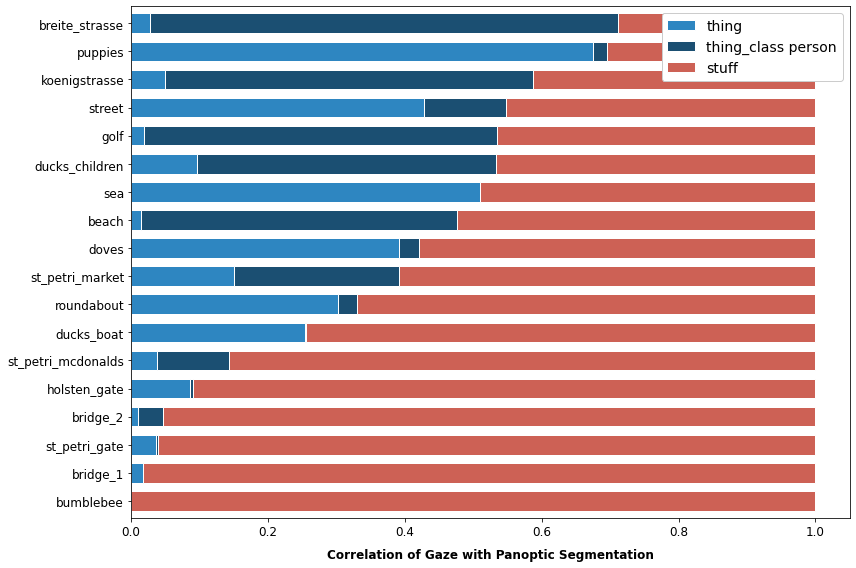

In [322]:
video_names = df_foveation.video.unique()
percent_person
df_bar = pd.DataFrame({'thing': percent_thing,
                    'thing_class person': percent_person,
                   'stuff': percent_stuff}, index=video_names)
df_bar = df_bar.sort_values(by=['stuff'],ascending=False)
df_bar.plot(kind='barh', label='Correlation of Gaze with Panoptic thing', color={"#2E86C1": "thing", "#1B4F72": "thing_class person", "#CD6155" : "stuff"}, stacked = True, fontsize=12, figsize=(12,8), edgecolor = "white", width=0.7)
#plt.xticks(rotation='vertical')


plt.xlabel('Correlation of Gaze with Panoptic Segmentation',labelpad=10, weight='bold', size=12)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)
plt.tight_layout()
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/corr_pan_thing',dpi= 500)


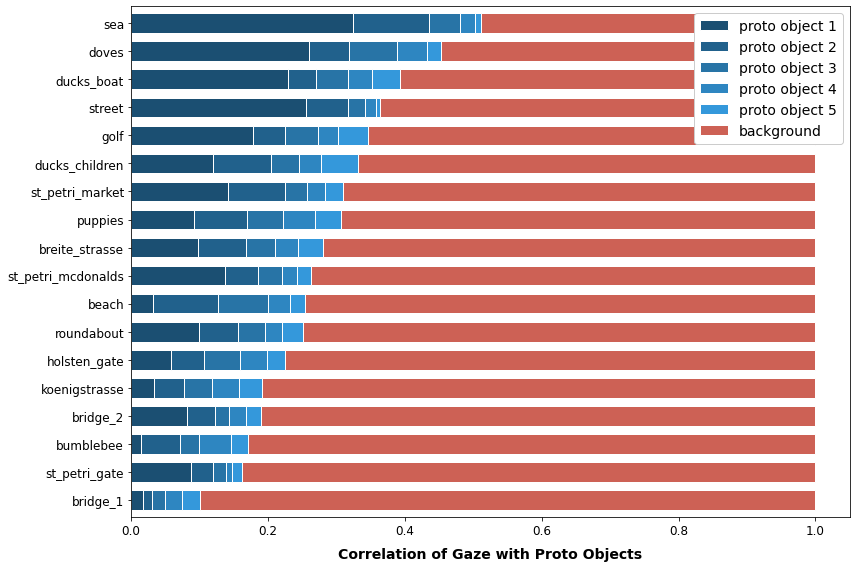

In [323]:
video_names = df_foveation.video.unique()
df_bar = pd.DataFrame({'proto object 1': percent_proto1,
                        'proto object 2': percent_proto2,
                        'proto object 3': percent_proto3,
                        'proto object 4': percent_proto4,
                        'proto object 5': percent_proto5,
                        'background': percent_background
                        }
                        ,index = video_names)
df_bar = df_bar.sort_values(by=['background'],ascending=False)
df_bar.plot(kind='barh', label='Correlation of Gaze with Proto Obejcts', stacked=True, color={"#1B4F72", "#21618C", "#2874A6","#2E86C1","#3498DB","#CD6155"},rot=0, fontsize=12, figsize=(12,8), edgecolor = "white", width=0.7)
plt.legend(loc=1, facecolor='white', framealpha=1, fontsize=14)
plt.xlabel('Correlation of Gaze with Proto Objects',labelpad=10, weight='bold', size=14)
plt.tight_layout()
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/thesis/images/corr_proto_object.png',dpi= 500)
